# Training Walkthrough
Sebastian Peck, June 4th 2024

This is a notebook-level walthrough of the training process for our current model.

In [1]:
# First, we import all the relevant packages:
# Base packages for data processing and cleanliness
import os
import sys
import numpy as np
import subprocess
import multiprocessing
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import random
import datetime

# adjust the path to include the directory for our own python files
sys.path.append('..//..//model_gen')
import feature_extraction as fe

In [2]:
# Then,the machine learning packages
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns

# and setup the device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [3]:
# set up the operational directories

# working directory, reference fasta, etc. The stuff typically handled by the pipeline
working_directory = '/media/sebastian/Slepnir/xenofind_datasets/Working_directory_PZ/'
ref_fasta = "/media/sebastian/Slepnir/xenofind_datasets/xref_libv2_PZ_CxDx.fa"
working_subdir=''
fasta_path = ''
IS_TRAINING = True
GLOBAL_RANDOM_STATE = 0
window_size = 3

# set up the random seed
random.seed(0)

if IS_TRAINING:
    fasta_path = ref_fasta
    working_subdir = 'model_training/'
else:
    working_subdir = 'model_testing/'
    fasta_path = working_directory + working_subdir + 'consensus.fa'
    
bam_path = working_directory + working_subdir + 'basecall_directory/fwd_filtered.bam'
pod5_path = working_directory + working_subdir + 'merged_pod5/merged.pod5'
json_dir = working_directory + working_subdir + 'json_files/'
parquet_dir = working_directory + working_subdir + 'parquet_superdirectory/'
singlet_consensus_dir = working_directory + working_subdir + "json_feature_files/"
model_dir = working_directory + working_subdir + 'Models/'


### Custom Methods for modeling:
percenttobar - takes a fraction and converts it to a loading bar string 


find_pca_components - generates a list of explained variance as percent for each number of components 


PyTorchClassifier - A custom sklearn-styled classifyer for generating a variable pytorch model

In [4]:
def percenttobar(frac):
    bar_str = "|"
    max_bars = 20
    perc = frac*2000
    n_bars = int(perc/100)
    for i in range(n_bars):
        bar_str += "="
    for i in range(max_bars-n_bars):
        bar_str += " "
    bar_str += "|  {}%                ".format(round(frac*100, 3))
    return bar_str
    
def find_pca_components(comp_list, data):
    '''
    find_pca_components takes in a list of number of components to be used,
    as well as feature data to be used for PCA, and returns the
    list of total explained variance as a percent for each number of components.
    
    Parameters:
    comp_list: List of ints representing number of components of interest
    data: pandas dataframe containing scaled unit variance feature data
    
    Returns:
    a list of explained variance as a percent for each number of components
    '''
    
    # Set up empty list
    explained = []
    # Loop through all components in the list
    for components in comp_list:
        # Set up PCA with the number of components of interest and the global random
        pca = PCA(n_components=components, random_state = GLOBAL_RANDOM_STATE)
        # Fit the data
        pca.fit(data)
        # Get the total explained variance ratio
        pcen_expl = (pca.explained_variance_ratio_).sum()
        # Add the value to the empty list
        explained.append(pcen_expl)
        
    # return the explained list
    return explained

class PyTorchClassifier:
    '''
    Originally written by S. Peck and A. Mahmoud, Adapted for this project by S. Peck, and is licensed for this sole implementation. 
    
    PyTorchClassifier - Sebastian Peck, 12/1/2023
    PyTorchClassifier is an sklearn-styled class to aid in
    the classification of data using a pytorch neural network.
    Initialization requires the device to run pytorch on,
    number of input features, and number of classes.
    
    Updated 6/4/2024 - S. Peck
    UPDATED 6/5/2024 - S. PECK
    
    '''
    def __init__(self,
                 device,
                 n_features:int,
                 out_features:int,
                 nl_list:list=[5, 5, 5],
                 activation_function=nn.ReLU(),
                 loss_function=nn.CrossEntropyLoss(),
                 n_epochs:int=1000,
                 learning_rate:float=.1,
                 random_state:int=42,
                 class_weights:list=[0]):
        '''
        initializing PyTorchClassifyer sets pytoch's random
        seed and generates the loss function, optimizer,
        and model of neural network based on passed parameters.
        
        Parameters:
        device: the device running pytorch
        n_features: number of features in data as int
        out_features: number of classes in the data as int
        nl_list: a list, with number of indexes as layers, 
                 and values representing neurons at that layer(as ints) Default = [5, 5, 5]
        activation_function: the torch.nn activation function of choice. Default = ReLU()
        loss_function: the torch.nn loss function of choice. Defualt = CrossEntropyLoss()
        n_epochs: int of number of epochs to perform when training. Default= 1000
        learning_rate: float representing learning rate. Defualt = .1
        random_state: the random state to use. Default = 42
        class_weights: List of class weights USED FOR BOOKKEEPING AND DOES NOT ACTUALLY PASS TO LOSS FXN.

        '''
        
        # Generate a string of the parameters
        self._param_string = (str(device) +'|'+ str(n_features) +'|'+ str(out_features) +'|'+ str(nl_list) +'|'+ str(activation_function) +'|'+str(loss_function)+'|'+ str(n_epochs) +'|'+ str(learning_rate) +'|'+ str(random_state) + '|' + str(class_weights))
        
        # assign the random seed to pytorch
        torch.manual_seed(random_state)
        
        # set the class variables
        self.epochs = n_epochs
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.device = device
        self.n_features = n_features
        self.random_state = random_state
        
        # Generate the model using the local ClassifierNetwork class
        self.model = (self.ClassifierNetwork(input_features=n_features,output_features=out_features,nl_list = nl_list, activation_function = self.activation_function)).to(device)
        
        # Optimize the model using SGD
        self.optimizer = torch.optim.SGD(params = self.model.parameters(), lr=learning_rate)
        

    
    def train_model(self, dataloader, epochs=None):
        if type(epochs) == type(None):epochs=self.epochs
        '''
        train_model takes in a torch formatted dataset of features,
        and the corresponding torch formatted dataset of classes,
        and trains the current model version on that data.
        
        Parameters:
        dataloader: a TensorDataset DataLoader object containing the data to be processed.
        epochs: an int representing number of epochs to train this dataset. Default is the passed epochs when creating the model.
        
        Returns:
        The trained model.
        '''
        
        # Set up the model to train
        self.model.train()
        
        # repeat for every epoch
        for epoch in range(epochs):
            
            
            # load a subset from the dataloader
            for i, (x, y) in enumerate(dataloader):
                
                # generate the features and classes
                features, classes = x.to(self.device), y.to(self.device)

                # Forward Pass - pass the features and
                # convert to class logits
                class_logits = self.model(features)

                # Convert the logits to probabilities to labels using softmax
                class_predictions = torch.softmax(class_logits, dim=1).argmax(dim=1)

                # Calculate loss
                # passing the logits and the training classes
                loss = self.loss_function(class_logits, classes)

                # Reset the optimizer gradient
                self.optimizer.zero_grad()

                # set backwards loss training
                loss.backward()

                # step the optimizer by one
                self.optimizer.step()
            print("{}  {}/{}         ".format(percenttobar(epoch/epochs), epoch, epochs), end="\r")
            
        # return the model
        return self.model
    
    
    def save_model_state(self, path, filename):
        '''
        save_model saves the model state to the given path.
        
        Parameters:
        path: path, as str, to the save location directory, must end with '/'
        filename: name of the file to be saved, as str
        
        Returns:
        path to saved file, as str
        '''
        
        # generate savefile strings for the state and parameters
        save_path_str = '{}{}/state.pt'.format(path, filename)
        save_path_str_2 = '{}{}/params.txt'.format(path, filename)
        
        if not os.path.isfile('{}{}'.format(path, filename)):
            os.mkdir('{}{}'.format(path, filename))
        
        # save the state
        torch.save(self.model.state_dict(), save_path_str)
        
        # save the parameters
        with open(save_path_str_2, 'w') as f:
            f.write(self._param_string)
        
        # return the directory
        return save_path_str
    
    
    def load_model_state(self, path):
        '''
        load_model_state loads the model state from a given path.
        
        Parameters:
        path: Path, as str, to the saved parameters file
        
        Returns:
        the loaded model, in evaluation state
        '''
        
        # load the model from the path
        self.model.load_state_dict(torch.load(path))

        # set the model into evaluation mode
        self.model.eval()
        
        # return the model
        return self.model
            
    
    def accuracy_score(self, y_true, y_pred):
        '''
        accuracy_score takes in two torch tensors of true and predicted values
        and returns the accuracy as a percentage fraction.
        
        Parameters:
        y_true: pytorch tensor of LongTensors representing classes of each point
        y_pred: pytorch tesnor of Longtensors representing predicted classses of each point
        
        Returns:
        the accuracy fraction
        '''
        
        # get number of the true predicted values to get the valid ones using torch.eq()
        valid = torch.eq(y_true, y_pred).sum().item()
        
        # Generate the precentage fraction
        acc = (valid/len(y_pred))
        
        # return the accuracy
        return acc
    
    
    def test_model(self, features, classes):
        '''
        test_model takes in a set of features and corresponding classes to
        test how the model performs with that dataset.
        
        Parameters:
        features: a pytorch tensor of floats representing the data for each feature
        classes: a pytorch tensor of LongTensors representing the classes for each point
        
        Returns:
        a touple containing the loss and the accuracy.
        
        '''
        
        # generate the logit values from the model by passing the test features
        test_logits = self.model(features)
        
        # generate the predictions using torch.softmax() and the test logits
        test_predictions = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        # Generate the loss using the class's loss function
        test_loss = self.loss_function(test_logits,
                                       classes)
        
        # Generate the accuracy score using the class accuracy score function
        test_acc = self.accuracy_score(classes,
                                       test_predictions)
        
        # Generate a string to hold the results for pretty-printing if needed
        #results = "Loss: {}, Accuracy Score: {}".format(test_loss, test_acc)
        #print(results)
        
        # return a touple of the loss value and the test accuracy.
        return (test_loss.item(), test_acc)
    
        
    class ClassifierNetwork(nn.Module):
        '''
        ClassifierNetwork is a subclass of the Pytorch nn.Module,
        which is meant to be used as a classifier.
        '''
        def __init__(self,
                     input_features:int,
                     output_features:int,
                     nl_list:list=[5, 5, 5],
                     activation_function=nn.ReLU()):
            '''
            Extends nn.Module.
            
            initializer sets up the model stack in sequential order according to the passed parameters.
            Uses linear layer stack of linear nn layers.
            
            Parameters:
            input_features: an int representing the number of features in the dataset
            output_features: an int representing the number of classes in the dataset
            nl_list: list representing number of neurons per layer,
                     with n indexes as the number of layers, Default = [5, 5, 5]
            activation_function: activation function of choice between layers. Default=nn.ReLU()
            
            Returns:
            N/A
            '''
            
            # Initialize the superclass
            super().__init__()
            
            # generate the starting neurons as the first index in the list
            starting_neurons = nl_list[0]
            
            # set up a sequential stack
            self.linear_layer_stack = nn.Sequential()
            
            # add the first layer where the input features is the first number of neurons, and the output features are the starting neurons
            self.linear_layer_stack.append(nn.Linear(in_features = input_features, out_features = starting_neurons))
            
            
            # loop through each layer of the nl_list.
            for i in range(len(nl_list)-1):
                # append the activation function to the linear layer stack
                self.linear_layer_stack.append(activation_function)

                # append a new layer where the input features is the current index in the nl_list, and the subsequent is the next.
                self.linear_layer_stack.append(nn.Linear(in_features=nl_list[i], out_features = nl_list[i+1]))
                
            # add the output layer
            self.linear_layer_stack.append(activation_function)
            self.linear_layer_stack.append(nn.Linear(in_features=nl_list[-1], out_features = output_features))


        def forward(self, x):
            '''
            forward takes in a set of features and applies it to the linear layer stack.
            
            Paramters:
            x: set of features. 
            
            Returns:
            the linear layer stack with the passed features.
            '''
            return self.linear_layer_stack(x)
        
        
    def __str__(self):
        '''
        export self as string.
        '''
        return self._param_string

In [5]:
def yoink_features(json_file,json_dir, singlet_consensus_dir, extracted_features):
    # THIS CODE IS PRESENTLY BAD AS IT REFERENCES GLOBAL item JSON_DIR
    if "{}.parquet".format(json_file) not in extracted_features:
        json_file_path = json_dir + json_file
        fe.feature_extraction(json_file_path).to_parquet(singlet_consensus_dir+"{}.parquet".format(json_file))

def json_to_singlets(json_dir, singlet_consensus_dir, batch_size=15):
    # List the files in the json directory
    json_files = os.listdir(json_dir)

    # get the files in the extracted features directory
    extracted_features = os.listdir(singlet_consensus_dir)

    # generate an empty list for read features
    feature_read_list = []

    # get the last time 
    last_time = datetime.datetime.now()

    # Get the batches of json files in the directory
    batched_json = [json_files[i:i+batch_size] for i in range(0, len(json_files), batch_size)]

        
    # set up dummy to hold run duration      
    dur = 0

    # loop through each batch in the batched json files
    for i in range(len(batched_json)):

        # get the batch of json files
        json_batch = batched_json[i]
        
        j = []
        s = []
        e = []
        for item in json_batch:
            j.append(json_dir)
            s.append(singlet_consensus_dir)
            e.append(extracted_features)
 
        zip_batch = list(zip(json_batch, j, s, e))

        # setup a multiprocessing pool matching the batch size
        with multiprocessing.Pool(batch_size) as pool:

            # run feature extraction on the json files in the pool using yoink_features
            feature_read_list.extend(pool.starmap(yoink_features, zip_batch))

        # Get the time estimate and duration
        time = datetime.datetime.now()
        dt = (time-last_time).total_seconds()
        dur += dt
        mean_time = dur/(i+1)
        est_time = datetime.timedelta(seconds = mean_time*len(batched_json))
        last_time=time

        # print an update on progress
        print(percenttobar(i*batch_size/len(json_files)) + "{}/{}   est_time:{} | {}".format(i*batch_size, len(json_files), est_time, datetime.timedelta(seconds=dur)),end='\r')
    print(percenttobar(1))

    
def get_features_from_singlets(singlet_consensus_dir):
    '''
    get_features_from_singlets takes in a singlet consensus directory,
    and then returns a list of dataframes of each reference sequence's consensus features.
    Parameters:
    singlet_consensus_dir: directory to all singlet consensus feature parquet files
    
    Returns:
    List of dataframes, with ecach index being a different reference sequence
    '''
    
    
    # get the extracted features in the directory
    extracted_features = os.listdir(singlet_consensus_dir)
    
    # generate an empty list to contain the features
    feature_read_list = []
    
    # loop through all the extracted feature files
    for i in range(len(extracted_features)):
        
        # append the parquet file to the feature read list after reading it using pandas
        feature_read_list.append(pd.read_parquet(singlet_consensus_dir+ extracted_features[i]))
        
        # print the progress
        print(percenttobar(i/len(extracted_features)) + "{}/{}     ".format(i, len(extracted_features)),end='\r')
    print(percenttobar(1))
        
    # return the features list
    return feature_read_list

### Importing the data
The data can come in either as Json files or parquet files. If the files are Json files, they will need to have their features extracted. Likewise, if they are parquets, you need to know their batching. For this model, we are merging all reads per reference sequence ot one set of consensus features per reference, from existing parquet files.

#### Json-To-Parquet:

In [ ]:
json_to_singlets(json_dir, singlet_consensus_dir, 20)

In [6]:
feature_read_list = get_features_from_singlets(singlet_consensus_dir)

|====================|  100%                   8191/8192     


In [7]:
raw_df= pd.concat(feature_read_list[10:])
n_bases = len(raw_df['XNA_PRESENT'])
n_xna = len(raw_df[raw_df['XNA_PRESENT'] == 1])
weights = torch.tensor([(1-((n_bases-n_xna)/(n_bases))), (1-(n_xna/(n_bases)))]).type(torch.float).to(device)

### Generating a model for XNA windows
The following is designed to setup a model to identify windows of potential interest for XNA.

#### Feature Extraction

In [8]:
def extract_training_dataframe(feature_read_list, window_size, n_strands_excluded = 10):
    
    # get the nmer window
    nmer_dim = window_size*2 + 1
    
    # generate empty list for windowed parameters
    windowed_params = []
    
    ind = 0
    # for eacah strand in the subset of strands we care about,
    for strand_features in feature_read_list[n_strands_excluded:]:
        
        # loop twice as many items as windows would fit in the strand
        for i in range(int(len(strand_features)/nmer_dim)*2):
            
            # generate a random base position in the strand
            random_base_pos = random.randrange(window_size, len(strand_features)-window_size-1, 1)
            
            # get the upper and lower indexes for the base window
            upper = random_base_pos + window_size + 1
            lower = random_base_pos - window_size
            
            # get the subset of the bases in the strand corresponding to the window
            strand_features_subset = strand_features[lower:upper]
            
            #check if xna is present in the subset
            xna_present = len(strand_features_subset[strand_features_subset['XNA_PRESENT'] > 0].index.tolist())>0
            
            # get the features for the xna window
            features_2d = strand_features_subset.loc[:, strand_features_subset.columns != 'XNA_PRESENT']
            
            # convert to a long 1d array of features for each base in the window
            features_long = [x for xs in features_2d.values for x in xs]
            
            # append the features and xna_present to the windowed_praams list
            windowed_params.append({'XNA_PRESENT': int(xna_present), 'window_features':features_long})
        ind += 1
        print(percenttobar(ind/len(feature_read_list[n_strands_excluded:])) + "{}/{}     ".format(ind, len(feature_read_list[n_strands_excluded:])),end='\r')
    print(percenttobar(1))
        
    
    # generate a dataframe of the windowed params
    window_df = pd.DataFrame(windowed_params)
    
    # get the features of the windowed_dataframe
    window_df_features = pd.DataFrame.from_dict(dict(zip(window_df['window_features'].index, window_df['window_features'].values))).T
    
    # make a column where the XNA is present and reset to window_df
    window_df_features['XNA_PRESENT'] = window_df['XNA_PRESENT']
    window_df= window_df_features
    
    # Get all the windows that have an XNA
    xna_windows = window_df[window_df['XNA_PRESENT'] == 1]
    
    # Get all the windows without XNA
    rand_windows = window_df[window_df['XNA_PRESENT'] == 0]#.sample(n=len(xna_windows), random_state=0)
    
    # combine into a single dataframe
    training_df = pd.concat([xna_windows, rand_windows]).reset_index(drop=True)
    
    return training_df

In [ ]:
training_df = extract_training_dataframe(feature_read_list, 3, 10)

In [ ]:
def plot_component_explained_variance(component_range, scaled_features):
    '''
    plot_component_explained_variances generates plots of the explained variance as
    a function of PCA components by using find_pca_components.
    
    Parameters:
    Component_range: max number of components to examine.
    scaled_features: features that have been scaled with standardscaler
    
    Returns:
    N/A
    '''

    component_list = list(np.arange(1,component_range, 1))
    explained_variances = find_pca_components(component_list, scaled_features)

    dy = np.diff(explained_variances)
    dx = np.diff(component_list)

    deriv = dy/dx
    fig, ax = plt.subplots(1,2, figsize = (10,5))
    ax[0].plot(component_list, explained_variances)
    ax[0].grid()
    ax[0].set_title('Total Explained Variance Ratio vs n_components')
    ax[0].set_xlabel('n_components')
    ax[0].set_ylabel('Total Explained Variance Ratio')
    ax[1].plot(component_list[1:], dy/dx)
    ax[1].grid()
    ax[1].set_title('Rate of change of EV vs n_components')
    ax[1].set_xlabel('n_components')
    ax[1].set_ylabel('Rate of Change of EV Ratio')
    print()

In [ ]:
features = training_df.loc[:, training_df.columns != 'XNA_PRESENT']
labels = training_df['XNA_PRESENT']

scaler = StandardScaler()

scaled_features = features.copy()
scaled_features = pd.DataFrame(scaler.fit_transform(scaled_features))

In [ ]:
#plot_component_explained_variance(50, scaled_features)

From this, we can then generate an ideal PCA that maximizes EVR and minimizes components.

In [ ]:
# Set the number of components
comp = 26

# generate PCA
pca = PCA(n_components = comp, random_state=GLOBAL_RANDOM_STATE)

# fit the scaled features to the pca
pca.fit(scaled_features)

# transform the features with pca
x_pca = pca.transform(scaled_features)

# get the explained variance ratios
evrs = pca.explained_variance_ratio_

# get the PCA datagrame
pca_df = pd.DataFrame(x_pca)

#reset the index of labels. Not sure why i have this here.
labels.reset_index(drop=True)

# split the pca features and labels to train-test, size 30%
x_tr, x_te, y_tr, y_te = train_test_split(pca_df,
                                          labels,
                                          test_size=0.0001,
                                          random_state = GLOBAL_RANDOM_STATE)

print("Component Variance Ratio: ", evrs)
print("Total Explained Variance Ratio: ", evrs.sum())

In [ ]:
import pickle as pk 
pk.dump(pca, open('/media/sebastian/Slepnir/xenofind_datasets/Working_directory_PZ/model_training/Models/window_model_v1/'+"pca.pkl","wb"))

In [ ]:
# set up the model 

# Convert training data to tensors
tr_x_tensor = torch.tensor(x_tr.values).type(torch.float)
tr_y_tensor = torch.tensor(np.asarray(y_tr)).type(torch.LongTensor)

# generate the dataloader
training_dataset = torch.utils.data.TensorDataset(tr_x_tensor, tr_y_tensor)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size = int(len(tr_x_tensor)/4), shuffle=True)

# Convert testing data to tensors
te_x_tensor = torch.tensor(x_te.values).type(torch.float).to(device)
te_y_tensor = torch.tensor(np.asarray(y_te)).type(torch.LongTensor).to(device)

# PARAMS FOR 7-mer:
# number of features
feature_num = tr_x_tensor.shape[1]
out_features = 2
epochs = 1000
l_rate = .01
rs=42
nl_list = [52, 78, 13]
loss_fxn = nn.CrossEntropyLoss()
actv_fxn = nn.Tanh()

# generate the window model. 
window_model = PyTorchClassifier(device=device,
                            n_features = feature_num,
                            out_features = out_features,
                            nl_list = nl_list,
                            activation_function = actv_fxn,
                            loss_function = loss_fxn,
                            n_epochs=epochs,
                            learning_rate=l_rate,
                            random_state=rs)
#window_model.load_model_state(model_dir + 'prelim_window_model.pt')


#### Param optimization

In [32]:
import itertools
param_dict = {'device':[device],
              'n_features':[comp],
              'out_features':[2],
              'nl_list':[[comp^2, comp, int(comp/2)],
                         [int(((comp-1)^2 + (comp-1)) / 2), comp^2, comp*2, int(comp/2)],
                         [comp*2, comp*3, int(comp/2)],
                         [int(comp/2)],
                         [comp*2]],
              'activation_function':[nn.Tanh()],
              'loss_function':[nn.CrossEntropyLoss(), nn.CrossEntropyLoss(weight=weights)],
              'epochs':[12],
              'learning_rate':[1, .5, .1, .05, .01],
              'random_state':[42]}

param_keys = list(param_dict.keys())
param_lists = []

for key in param_keys:
    value_list = param_dict[key]
    param_lists.append(value_list)
    
model_combos = list(itertools.product(*param_lists))
model_combos[]

[('cuda', 26, 2, [24, 26, 13], Tanh(), CrossEntropyLoss(), 12, 1, 42),
 ('cuda', 26, 2, [24, 26, 13], Tanh(), CrossEntropyLoss(), 12, 0.5, 42),
 ('cuda', 26, 2, [24, 26, 13], Tanh(), CrossEntropyLoss(), 12, 0.1, 42),
 ('cuda', 26, 2, [24, 26, 13], Tanh(), CrossEntropyLoss(), 12, 0.05, 42),
 ('cuda', 26, 2, [24, 26, 13], Tanh(), CrossEntropyLoss(), 12, 0.01, 42),
 ('cuda', 26, 2, [24, 26, 13], Tanh(), CrossEntropyLoss(), 12, 1, 42),
 ('cuda', 26, 2, [24, 26, 13], Tanh(), CrossEntropyLoss(), 12, 0.5, 42),
 ('cuda', 26, 2, [24, 26, 13], Tanh(), CrossEntropyLoss(), 12, 0.1, 42),
 ('cuda', 26, 2, [24, 26, 13], Tanh(), CrossEntropyLoss(), 12, 0.05, 42),
 ('cuda', 26, 2, [24, 26, 13], Tanh(), CrossEntropyLoss(), 12, 0.01, 42),
 ('cuda', 26, 2, [1, 24, 52, 13], Tanh(), CrossEntropyLoss(), 12, 1, 42),
 ('cuda', 26, 2, [1, 24, 52, 13], Tanh(), CrossEntropyLoss(), 12, 0.5, 42),
 ('cuda', 26, 2, [1, 24, 52, 13], Tanh(), CrossEntropyLoss(), 12, 0.1, 42),
 ('cuda', 26, 2, [1, 24, 52, 13], Tanh(), Cr

In [77]:
results_dict = {}

# Iteration index for keeping progress
i = 0

# Loop through each possible combination of parameters.
for params in model_combos:

    # Print percentage progress
    print("{}                    {}/{}      ".format(percenttobar(i/len(model_combos)), i, len(model_combos)),end='\r')
    
    # Generate the model from the current parameters
    test_model = PyTorchClassifier(*params)
    
    # Here, we generate the key of the model based on it's params
    key = str(params)
    # Train the model
    test_model.train_model(training_dataloader)
    
    # Test the model on training and testing data
    train_loss, train_acc = test_model.test_model(tr_x_tensor[:1000].to(device), tr_y_tensor[:1000].to(device))
    test_loss, test_acc = test_model.test_model(te_x_tensor, te_y_tensor)
    
    # Return the results to the dictionary
    results_dict[key] = [train_acc, test_acc]
    torch.cuda.memory_summary(device=None, abbreviated=False)
    torch.cuda.empty_cache()

    # Incriment the progress tracker
    i+=1

===============  |  91.667%                  11/12               49/50      

In [84]:
results_df = pd.DataFrame(results_dict).T
results_df.sort_values(by=[0], ascending=False)

,0,1
"('cuda', 26, 2, [13], Tanh(), CrossEntropyLoss(), 12, 1, 42)",0.870,0.871123
"('cuda', 26, 2, [52, 78, 13], Tanh(), CrossEntropyLoss(), 12, 0.1, 42)",0.857,0.841705
"('cuda', 26, 2, [52], Tanh(), CrossEntropyLoss(), 12, 0.5, 42)",0.837,0.817089
"('cuda', 26, 2, [52], Tanh(), CrossEntropyLoss(), 12, 1, 42)",0.803,0.796023
"('cuda', 26, 2, [24, 26, 13], Tanh(), CrossEntropyLoss(), 12, 0.1, 42)",0.781,0.762980
"('cuda', 26, 2, [52, 78, 13], Tanh(), CrossEntropyLoss(), 12, 0.05, 42)",0.778,0.765307
"('cuda', 26, 2, [13], Tanh(), CrossEntropyLoss(), 12, 0.5, 42)",0.747,0.753053
"('cuda', 26, 2, [52], Tanh(), CrossEntropyLoss(), 12, 0.1, 42)",0.713,0.711262
"('cuda', 26, 2, [52], Tanh(), CrossEntropyLoss(), 12, 0.05, 42)",0.704,0.698687
"('cuda', 26, 2, [13], Tanh(), CrossEntropyLoss(), 12, 0.1, 42)",0.702,0.715315


#### window model testing

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)
torch.cuda.empty_cache()

In [ ]:
window_model.train_model(training_dataloader)

torch.cuda.memory_summary(device=None, abbreviated=False)
torch.cuda.empty_cache()

In [ ]:
# get and report the loss and accuracies.
train_loss, train_acc = window_model.test_model(tr_x_tensor[:1000].to(device), tr_y_tensor[:1000].to(device))
test_loss, test_acc = window_model.test_model(te_x_tensor, te_y_tensor)

print("Training: {}, Testing: {}".format(train_acc, test_acc))
# generate a confusion matrix for the overall model. 
cm = confusion_matrix(te_y_tensor.tolist(), torch.softmax(window_model.model(torch.tensor(x_te.values).type(torch.float).to(device)), dim=1).argmax(dim=1).tolist())
fig, ax = plt.subplots(1, figsize=(2.5, 2))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
plt.show()

In [ ]:
window_model.save_model_state(model_dir, 'window_model_v1')

#### preliminary evaluation

In [ ]:
# Generate an empty list to hold the number of windows classified.
n_classified = []

# for each of the first ten consensus strands.
for j in range(10):
    
    test_consensus = feature_read_list[j]
    # batch the bases into windows of size seven
    base_windows= [test_consensus[i:int(i+window_size*2+1)] for i in range(0, len(test_consensus), int(window_size*2+1))]
    
    # set up lists for window classes and features
    window_classes = []
    window_features = []
    
    # for each window minus the potentially inconsistently sized one,
    for base_window in base_windows[:-1]:
        
        # generate an empty list for the window's 1d features
        window_sub_features = []
        
        # check if there's an XNA, append a 1 to the classes if so.
        if len(base_window[base_window['XNA_PRESENT'] > 0]) > 0:
            window_classes.append(1)
        else:
            window_classes.append(0)
            
        # loop through each base features, and extend the features to the 1d feature array
        for base in base_window.drop(columns=['XNA_PRESENT']).values:
            window_sub_features.extend(base)
            
        # append the window's 1d features to the list.
        window_features.append(window_sub_features)
    
    
    # Create a scaler for the window's features
    scale = scaler.fit_transform(window_features)
    
    # generate the features and labels as tensors
    strand_features = torch.tensor(pca.transform(scale)).type(torch.float).to(device)
    strand_labels = torch.tensor(np.asarray(window_classes)).type(torch.LongTensor).to(device)
    
    # generate the logits of the model for the fiven features and labels
    strand_logits = window_model.model(strand_features)

    # get the predictions
    strand_predictions = torch.softmax(strand_logits, dim=1).argmax(dim=1)
    
    # get the predictions list
    predictions = strand_predictions.tolist()
    
    # get the true labels
    trues = strand_labels.tolist()
    
    # get the predicted series
    pred_series=pd.Series(predictions)

    # generate a confusion matrix for the current strand for validation. 
    cm = confusion_matrix(trues, predictions)
    fig, ax = plt.subplots(1, figsize=(2.5, 2))
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title("Confusion Matrix")
    
    # print the window. 
    print(list(zip(np.asarray(pred_series[pred_series> 0].index.tolist())*(window_size*2+1), (np.asarray(pred_series[pred_series> 0].index.tolist())+1)*(window_size*2+1))))
    plt.show()
    n_classified.append(len(pred_series[pred_series> 0].index.tolist()))

    

In [ ]:
# clear the cuda memory cache.
torch.cuda.memory_summary(device=None, abbreviated=False)
torch.cuda.empty_cache()

### Generating a model for bases in XNA window
The following is designed to set up a model for the XNA within a window to differentiate once a window has been found. 

In [ ]:
def generate_xna_window_data(feature_read_list, nmer_dim=7, n_strands_excluded = 10):
    '''
    generate_xna_window_data is designed to extract the features of all the surrounding bases
    of an xna given a defined window.
    
    Parameters:
    feature_read_list: a list of pandas dataframes that have the strands and their features
    nmer_dim: the window size, (number of bases on each side of the xna + 1), Default = 7
    n_strands_excluded: number of strands excluded from the data extraction. Default = 10
    
    Returns:
    pandas dataframe containing the features of all the bases in each window and their classes
    '''
    # generate empty list to hold xna windows
    xna_windows = []
    
    # loop throuch each strand
    for strand_features in feature_read_list[n_strands_excluded:]:

        # get the xna base position in the strand
        xna_base_pos = strand_features[strand_features['XNA_PRESENT'] > 0].index[0]
        
        # get the upper and lower bounds of the window
        upper_bound = xna_base_pos + nmer_dim
        lower_bound = xna_base_pos - nmer_dim +1
        
        # get all the bases within that band
        xna_windows.append(strand_features[lower_bound:upper_bound])

    # generate a dataframe of the extracted bases
    base_training_df = pd.concat(xna_windows).reset_index(drop=True)
    
    return base_training_df

In [ ]:
base_training_df = generate_xna_window_data(feature_read_list, 7, 10)

In [ ]:
base_features = base_training_df.loc[:, base_training_df.columns != 'XNA_PRESENT']
base_labels = base_training_df['XNA_PRESENT']

base_scaler = StandardScaler()

base_scaled_features = base_features.copy()
base_scaled_features = pd.DataFrame(base_scaler.fit_transform(base_scaled_features))

#plot_component_explained_variance(50, base_scaled_features)

In [ ]:
b_pca = PCA(n_components = 26, random_state=GLOBAL_RANDOM_STATE)
b_pca.fit(base_scaled_features)
b_x_pca = b_pca.transform(base_scaled_features)
b_evrs = b_pca.explained_variance_ratio_

base_labels.reset_index(drop=True)

print("Component Variance Ratio: ", b_evrs)
print("Total Explained Variance Ratio: ", b_evrs.sum())

b_pca_df = pd.DataFrame(b_x_pca)
base_labels.reset_index(drop=True)
b_x_tr, b_x_te, b_y_tr, b_y_te = train_test_split(b_pca_df,
                                          base_labels,
                                          test_size=.001,
                                          random_state = GLOBAL_RANDOM_STATE)

In [ ]:
import pickle as pk 
pk.dump(b_pca, open('/media/sebastian/Slepnir/xenofind_datasets/Working_directory_PZ/model_training/Models/base_model_v1/'+"pca.pkl","wb"))

In [40]:
# Convert training data to tensors
tr_x_tensor = torch.tensor(b_x_tr.values).type(torch.float)
tr_y_tensor = torch.tensor(np.asarray(b_y_tr)).type(torch.LongTensor)

# generate the dataloader
training_dataset = torch.utils.data.TensorDataset(tr_x_tensor, tr_y_tensor)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size = int(len(tr_x_tensor)), shuffle=True)

# Convert testing data to tensors
te_x_tensor = torch.tensor(b_x_te.values).type(torch.float).to(device)
te_y_tensor = torch.tensor(np.asarray(b_y_te)).type(torch.LongTensor).to(device)


# number of features
feature_num = tr_x_tensor.shape[1]
out_features = 2
epochs = 10
l_rate = .1
rs=42
nl_list = [676, 338, 100, 10]

# optuna - hyperparameter optimization

loss_fxn = nn.CrossEntropyLoss(weight=weights)
actv_fxn = nn.Tanh()

XNA Identifier Model Training: 0.23793749235358888, Testing: 0.24299065420560748


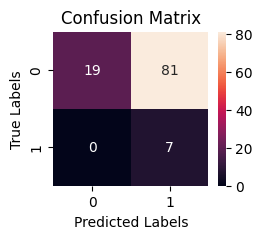

In [42]:
base_model = PyTorchClassifier(device=device,
                            n_features = feature_num,
                            out_features = out_features,
                            nl_list = nl_list,
                            activation_function = actv_fxn,
                            loss_function = loss_fxn,
                            n_epochs=epochs,
                            learning_rate=l_rate,
                            random_state=rs)

base_model.train_model(training_dataloader)
train_loss, train_acc = base_model.test_model(tr_x_tensor.to(device), tr_y_tensor.to(device))
test_loss, test_acc = base_model.test_model(te_x_tensor, te_y_tensor)

print("XNA Identifier Model Training: {}, Testing: {}".format(train_acc, test_acc))
#print("Training misclassified/strand: {}, Testing misclassified/strand: {}".format(1-(132-train_acc.item()*132),1-(132-test_acc.item()*132)))
test_consensus = feature_read_list[0]
#bPTmodel.model(torch.tensor(pca.transform(test_consensus.loc[:, test_consensus.columns != 'XNA_PRESENT'])).type(torch.float).to(device))[66]

cm = confusion_matrix(te_y_tensor.tolist(), torch.softmax(base_model.model(torch.tensor(b_x_te.values).type(torch.float).to(device)), dim=1).argmax(dim=1).tolist())
fig, ax = plt.subplots(1, figsize=(2.5, 2))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
plt.show()

In [43]:
n_classified = []

# loop through the first ten strands
for j in range(10):
    
    # get the strand data
    test_consensus = feature_read_list[j]
    
    #---- ------ ---- ------ WINDOW MODELING ---- ------ ----- ------ ----- #
    # batch the bases into windows of size seven
    base_windows= [test_consensus[i:int(i+window_size*2+1)] for i in range(0, len(test_consensus), int(window_size*2+1))]
    
    # set up lists for window classes and features
    window_classes = []
    window_features = []
    
    # for each window minus the potentially inconsistently sized one,
    for base_window in base_windows[:-1]:
        
        # generate an empty list for the window's 1d features
        window_sub_features = []
        
        # check if there's an XNA, append a 1 to the classes if so.
        if len(base_window[base_window['XNA_PRESENT'] > 0]) > 0:
            window_classes.append(1)
        else:
            window_classes.append(0)
            
        # loop through each base features, and extend the features to the 1d feature array
        for base in base_window.drop(columns=['XNA_PRESENT']).values:
            window_sub_features.extend(base)
            
        # append the window's 1d features to the list.
        window_features.append(window_sub_features)
    
    # Create a scale of the window features + convert to tensors for features and labels
    scale = scaler.fit_transform(window_features)
    strand_features = torch.tensor(pca.transform(scale)).type(torch.float).to(device)
    strand_labels = torch.tensor(np.asarray(window_classes)).type(torch.LongTensor).to(device)
    
    # pass window features to models for strands
    strand_logits = window_model.model(strand_features)

    # Get the predictions for the model
    strand_predictions = torch.softmax(strand_logits, dim=1).argmax(dim=1)
    
    #convert the predictions to a list
    predictions = strand_predictions.tolist()
    
    # get the true window predictions as a list
    trues = strand_labels.tolist()
    
    # convert the predictions to a series
    pred_series=pd.Series(predictions)
    
    # get the lsit of windows predicted
    idd_windows = list(zip(np.asarray(pred_series[pred_series> 0].index.tolist())*(window_size*2+1), (np.asarray(pred_series[pred_series> 0].index.tolist())+1)*(window_size*2+1)))
    
    # ------ ------ ------ WINDOW BASE MODELING ------------------------#
    print("Sequence {}:".format(j+1))
    
    # generate an empty base list
    base_list = []
    
    # for each window in the predicted windows:
    for window in idd_windows:
        
        # get the base region from the strand as defined in the window
        xna_region = test_consensus[window[0]:window[1]]
        
        # get the features and classes
        xna_region_features = xna_region.loc[:, xna_region.columns != 'XNA_PRESENT']
        xna_region_classes = xna_region['XNA_PRESENT']
        
        # conform those to the base scaler
        base_scale = base_scaler.fit_transform(xna_region_features)
        
        # get the features and labels as tensors
        region_features = torch.tensor(b_pca.transform(base_scale)).type(torch.float).to(device)
        region_labels = torch.tensor(np.asarray(xna_region_classes)).type(torch.LongTensor).to(device)
        
        # generate the logits with the base_model
        region_logits = base_model.model(region_features)
        
        # get the predicted base classes
        xna_predictions = torch.softmax(region_logits, dim=1).argmax(dim=1)
        
        # get the list of predictions
        xna = xna_predictions.tolist()
        
        # get the true bases
        true_xna = region_labels.tolist()
        
        # get the series of predicted bases
        pred_xna_series = pd.Series(xna)
        
        # extend the identified base list with all bases identified as XNA by the model
        base_list.extend((np.asarray(pred_xna_series[pred_xna_series >0].index.tolist()) + window[0]).tolist())
        
    # report the identified regions and bases
    print("Identified Regions: {}".format(idd_windows))
    print("Identified Bases: {}".format(base_list))

    print("")

Sequence 1:
Identified Regions: [(0, 7), (7, 14), (14, 21), (21, 28), (35, 42), (49, 56), (56, 63), (70, 77), (77, 84), (84, 91), (91, 98), (105, 112), (112, 119), (119, 126)]
Identified Bases: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 35, 36, 37, 39, 40, 41, 49, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 105, 107, 108, 109, 110, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124]

Sequence 2:
Identified Regions: [(0, 7), (7, 14), (14, 21), (21, 28), (42, 49), (49, 56), (63, 70), (70, 77), (77, 84), (84, 91), (91, 98), (105, 112), (112, 119), (119, 126)]
Identified Bases: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 42, 43, 44, 46, 47, 48, 50, 51, 52, 53, 54, 55, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 93, 94, 95, 96, 105, 10

In [45]:
#window_model.save_model_state(model_dir, 'window_model_v1')
base_model.save_model_state(model_dir, 'base_model_v1')

'/media/sebastian/Slepnir/xenofind_datasets/Working_directory_PZ/model_training/Models/base_model_v1/state.pt'

### External Dataset Validaton

#### Model Loading

In [8]:
# Load the window_model
feature_num = 26
out_features = 2
epochs = 1000
l_rate = .01
rs=42
nl_list = [52, 2704, 55, 10]
loss_fxn = nn.CrossEntropyLoss()
actv_fxn = nn.Tanh()


loaded_window_model = PyTorchClassifier(device=device,
                            n_features = feature_num,
                            out_features = out_features,
                            nl_list = nl_list,
                            activation_function = actv_fxn,
                            loss_function = loss_fxn,
                            n_epochs=epochs,
                            learning_rate=l_rate,
                            random_state=rs)
loaded_window_model.load_model_state(model_dir + 'prelim_window_model.pt')

RuntimeError: Error(s) in loading state_dict for ClassifierNetwork:
	Missing key(s) in state_dict: "linear_layer_stack.8.weight", "linear_layer_stack.8.bias". 
	size mismatch for linear_layer_stack.6.weight: copying a param with shape torch.Size([2, 55]) from checkpoint, the shape in current model is torch.Size([10, 55]).
	size mismatch for linear_layer_stack.6.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([10]).

In [11]:
# load the base model
feature_num = 26
out_features = 2
epochs = 50
l_rate = .1
rs=42
nl_list = [400, 200, 20]

# optuna - hyperparameter optimization

loss_fxn = nn.CrossEntropyLoss(weight=torch.tensor([.0075, .9925]).type(torch.float).to(device))
actv_fxn = nn.Tanh()

loaded_base_model = PyTorchClassifier(device=device,
                            n_features = feature_num,
                            out_features = out_features,
                            nl_list = nl_list,
                            activation_function = actv_fxn,
                            loss_function = loss_fxn,
                            n_epochs=epochs,
                            learning_rate=l_rate,
                            random_state=rs)
loaded_base_model.load_model_state(model_dir+'prelim_base_model.pt')

ClassifierNetwork(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=26, out_features=400, bias=True)
    (1): Tanh()
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=2, bias=True)
  )
)

#### GC Dataset

In [70]:
import ast
import pickle as pk
DEVICE=(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

def run_check_device():
    d = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu")
    
    DEVICE = d
    return d


def activ_func_parser(act_str):
    '''
    parses an activity function string. Currently only works with nn.tanh()
    '''
    if act_str == 'Tanh()':
        return nn.Tanh()
    else:
        return nn.Tanh()

    
def loss_func_parser(loss_str, wt, device):
    '''
    parses a loss function string with weight and device. Currently only uses
    nn.CrossEntropyLoss()
    '''
    if len(wt) > 1:
        wt = torch.tensor(wt).type(torch.float).to(device)
        if loss_str == 'CrossEntropyLoss()':
            return nn.CrossEntropyLoss(weight = wt)
    else:
        return nn.CrossEntropyLoss()


def get_model_params(model_dir):
    '''
    generates the model paramater touple from a given model directory.
    assumes model directory contains 'params.txt'.
    '''
    DEVICE = run_check_device()
    param_string = None
    with open(model_dir+"params.txt", 'r') as f:
        param_string = f.readline()

    param_list = param_string.split("|")

    # Check if the device is matching the current device and update accordingly.

    if param_list[0] == DEVICE:
        DEVICE = param_list[0]
    else:
        param_list[0] = DEVICE

    param_list[9] = ast.literal_eval(param_list[9]) # weights notation

    param_list[1] = int(param_list[1]) # PCA features
    param_list[2] = int(param_list[2]) # Classes
    param_list[3] = ast.literal_eval(param_list[3]) # Network list
    param_list[4] = activ_func_parser(param_list[4]) # activation function
    param_list[5] = loss_func_parser(param_list[5], param_list[9], DEVICE) # loss function
    param_list[6] = int(param_list[6]) # epochs
    param_list[7] = float(param_list[7]) # learning rate
    param_list[8] = int(param_list[8]) # random state


    param_list = param_list[:-1]

    return tuple(param_list)


def load_models(window_model_dir, base_model_dir):
    '''
    this is very hastily written code and should be revised to be better. 
    forgive me :( -S
    '''
    run_check_device()
    # open params:
    window_model_params = get_model_params(window_model_dir)
    base_model_params = get_model_params(base_model_dir)
    
    #generate the models
    loaded_window_model = PyTorchClassifier(*window_model_params)
    loaded_base_model = PyTorchClassifier(*base_model_params)
    
    #load the model states
    loaded_window_model.load_model_state(window_model_dir + 'state.pt')
    loaded_base_model.load_model_state(base_model_dir + 'state.pt')
    
    return loaded_window_model, loaded_base_model


def load_pcas(window_model_dir, base_model_dir):
    '''
    Dave, I know this is bad code and bad ML but genuinely i am writing this on wednesday at 8:10 pm -S
    '''
    pca_window = pk.load(open(window_model_dir+"pca.pkl",'rb'))
    pca_base = pk.load(open(base_model_dir+"pca.pkl", 'rb'))
    return pca_window, pca_base


def window_detection(window_model, read_feature_df, pca):
    '''
    uses a window model to detect xna windows from the data
    '''
    DEVICE = run_check_device()
    # step 1: split the data into windows of size 7 ----------------
    window_size = 7
    windows = [read_feature_df[i:int(i+window_size)] for i in range(0, len(read_feature_df), int(window_size))]
    
    window_classes = []
    window_features = []
    
    # for each window minus the potentially inconsistently sized one,
    for base_window in windows[:-1]:
        
        # generate an empty list for the window's 1d features
        window_sub_features = []
        
        # check if there's an XNA, append a 1 to the classes if so. When testing, there should never be anything but zeroes here.
        if len(base_window[base_window['XNA_PRESENT'] > 0]) > 0:
            window_classes.append(1)
        else:
            window_classes.append(0)
            
        # loop through each base features, and extend the features to the 1d feature array
        for base in base_window.drop(columns=['XNA_PRESENT']).values:
            window_sub_features.extend(base)
            
        # append the window's 1d features to the list.
        window_features.append(window_sub_features)
        
    # step 2: scale the data.
    window_scaler = StandardScaler()
    scaled_features = window_scaler.fit_transform(window_features)
    
     # step 3as;lkvskvna;lkf: generate PCA - THIS IS BAD FORM AND SHOULD NOT BE DONE THIS WAY BUT TIME HAS FORCED MY HAND
    #n_pca_features = window_model.n_features
    #pca = PCA(n_components=n_pca_features, random_state = window_model.random_state)
    #pca = PCA.fit_transform(scaled_features)
    
    # step 4: generate the feature tensor and label tensor
    feature_tensor = torch.tensor(pca.transform(scaled_features)).type(torch.float).to(DEVICE)
    # --> unuused because it is only for training rn:  label_tensor = torch.tensor(np.asarray(window_classes)).type(torch.LongTensor).to(DEVICE)
    
    # step 5: run the model!
    window_logits = window_model.model(feature_tensor)
    
    # step 6: convert the model logits to predictions
    window_predictions = torch.softmax(window_logits, dim=1).argmax(dim=1)
    
    # step 7: extract the predicted windows:
    #convert the predictions to a list
    predictions = window_predictions.tolist()

    # convert the predictions to a series
    pred_series=pd.Series(predictions)
    
    # get the lsit of windows predicted
    idd_windows = list(zip(np.asarray(pred_series[pred_series> 0].index.tolist())*(window_size), (np.asarray(pred_series[pred_series> 0].index.tolist())+1)*(window_size)))
    
    return idd_windows
    

def windowed_base_detection(base_model, window, read_feature_df, pca):
    '''
    uses a base model to detect bases from a window
    '''
    DEVICE = run_check_device()
    
    # step 1: generate the detection region from the window
    window_bases = read_feature_df[window[0]:window[1]]
    
    # step 2: get the features and classes
    window_base_features = window_bases.loc[:, window_bases.columns != 'XNA_PRESENT']
    window_base_features = window_bases['XNA_PRESENT']


    # step 3: scale the data:
    base_scaler = StandardScaler()
    
    # For some heavens forsaken reason, this is the only way this runs and it wont work separated
    base_scale = StandardScaler().fit_transform(window_bases.loc[:, window_bases.columns != 'XNA_PRESENT'])

        
    # step 4: generate PCA - THIS IS BAD FORM AND SHOULD NOT BE DONE THIS WAY BUT TIME HAS FORCED MY HAND
    #n_pca_features = base_model.n_features
    #pca = PCA(n_components=n_pca_features, random_state = window_model.random_state)
    #pca.fit(scaled_features)
    
    # step 5: generate the feature and label tensors
    region_features = torch.tensor(pca.transform(base_scale)).type(torch.float).to(DEVICE)
    # UNUSED    region_labels = torch.tensor(np.asarray(xna_region_classes)).type(torch.LongTensor).to(device)
        
    # step 6: Run the model! 
    region_logits = base_model.model(region_features)
        
    # step 7: get the predicted base classes
    xna_predictions = torch.softmax(region_logits, dim=1).argmax(dim=1)
        
    # step 8: get the list of predictions
    xna = xna_predictions.tolist()

    # get the series of predicted bases
    pred_xna_series = pd.Series(xna)
    
    # return a list of the bases id'd as XNA. 
    return (np.asarray(pred_xna_series[pred_xna_series >0].index.tolist()) + window[0]).tolist()
                     


In [2]:
import modeling

In [1]:
window_model_dir = '/media/sebastian/Slepnir/xenofind_datasets/Working_directory_PZ/model_training/Models/window_model_v1/'
base_model_dir = '/media/sebastian/Slepnir/xenofind_datasets/Working_directory_PZ/model_training/Models/base_model_v1/'

In [9]:
# Generate the models and load the pca I KNOW THATS NOT GOOD BUT I NEED TO DO IT
w_m, b_m = modeling.load_models(window_model_dir, base_model_dir)
w_p, b_p = modeling.load_pcas(window_model_dir, base_model_dir)

# gEnerate the windowwZsd
windows = modeling.window_detection(w_m, feature_read_list[0], w_p)

# GENERATE THE aoutput ductuinary pof identified windows and their bases
out_dict = {}
for window in windows:
    out_dict[str(window)] = modeling.windowed_base_detection(b_m, window, feature_read_list[0], b_p)

In [10]:
out_dict

{'(0, 7)': [0, 1, 3, 4, 5, 6],
 '(7, 14)': [7, 8, 9, 10, 11, 12, 13],
 '(14, 21)': [14, 15, 16, 17, 19, 20],
 '(21, 28)': [22, 23, 24, 25, 26, 27],
 '(35, 42)': [35, 36, 37, 39, 40, 41],
 '(49, 56)': [49, 51, 52, 53, 54, 55],
 '(56, 63)': [56, 58, 59, 60, 61, 62],
 '(70, 77)': [70, 71, 72, 73, 74, 75, 76],
 '(77, 84)': [77, 78, 80, 81, 82, 83],
 '(84, 91)': [84, 85, 86, 87, 89, 90],
 '(91, 98)': [91, 92, 93, 94, 95, 96],
 '(105, 112)': [105, 107, 108, 109, 110],
 '(112, 119)': [113, 114, 116, 117, 118],
 '(119, 126)': [119, 120, 121, 122, 123, 124]}

#### The following dont work because the data is too big

In [ ]:
GC_json_dir='/media/sebastian/Slepnir/xenofind_datasets/0604_testing_datasets/GC_center_null_dataset/xna_find/json_files/'
GC_singlet_dir = '/media/sebastian/Slepnir/xenofind_datasets/0604_testing_datasets/GC_center_null_dataset/xna_find/parquet_superdirectory/'
json_to_singlets(GC_json_dir, GC_singlet_dir, 1)
GC_feature_list = get_features_from_singlets(GC_singlet_dir)

In [ ]:
n_classified = []

# loop through the first ten strands
for j in range(len(GC_feature_list)):
    
    # get the strand data
    test_consensus = GC_feature_list[j]
    
    #---- ------ ---- ------ WINDOW MODELING ---- ------ ----- ------ ----- #
    # batch the bases into windows of size seven
    base_windows= [test_consensus[i:int(i+window_size*2+1)] for i in range(0, len(test_consensus), int(window_size*2+1))]
    
    # set up lists for window classes and features
    window_classes = []
    window_features = []
    
    # for each window minus the potentially inconsistently sized one,
    for base_window in base_windows[:-1]:
        
        # generate an empty list for the window's 1d features
        window_sub_features = []
        
        # check if there's an XNA, append a 1 to the classes if so.
        if len(base_window[base_window['XNA_PRESENT'] > 0]) > 0:
            window_classes.append(1)
        else:
            window_classes.append(0)
            
        # loop through each base features, and extend the features to the 1d feature array
        for base in base_window.drop(columns=['XNA_PRESENT']).values:
            window_sub_features.extend(base)
            
        # append the window's 1d features to the list.
        window_features.append(window_sub_features)
    
    # Create a scale of the window features + convert to tensors for features and labels
    scale = scaler.fit_transform(window_features)
    strand_features = torch.tensor(pca.transform(scale)).type(torch.float).to(device)
    strand_labels = torch.tensor(np.asarray(window_classes)).type(torch.LongTensor).to(device)
    
    # pass window features to models for strands
    strand_logits = loaded_window_model.model(strand_features)

    # Get the predictions for the model
    strand_predictions = torch.softmax(strand_logits, dim=1).argmax(dim=1)
    
    #convert the predictions to a list
    predictions = strand_predictions.tolist()
    
    # get the true window predictions as a list
    trues = strand_labels.tolist()
    
    # convert the predictions to a series
    pred_series=pd.Series(predictions)
    
    # get the lsit of windows predicted
    idd_windows = list(zip(np.asarray(pred_series[pred_series> 0].index.tolist())*(window_size*2+1), (np.asarray(pred_series[pred_series> 0].index.tolist())+1)*(window_size*2+1)))
    
    # ------ ------ ------ WINDOW BASE MODELING ------------------------#
    print("Sequence {}:".format(j+1))
    
    # generate an empty base list
    base_list = []
    
    # for each window in the predicted windows:
    for window in idd_windows:
        
        # get the base region from the strand as defined in the window
        xna_region = test_consensus[window[0]:window[1]]
        
        # get the features and classes
        xna_region_features = xna_region.loc[:, xna_region.columns != 'XNA_PRESENT']
        xna_region_classes = xna_region['XNA_PRESENT']
        
        # conform those to the base scaler
        base_scale = base_scaler.fit_transform(xna_region_features)
        
        # get the features and labels as tensors
        region_features = torch.tensor(b_pca.transform(base_scale)).type(torch.float).to(device)
        region_labels = torch.tensor(np.asarray(xna_region_classes)).type(torch.LongTensor).to(device)
        
        # generate the logits with the loaded base_model
        region_logits = loaded_base_model.model(region_features)
        
        # get the predicted base classes
        xna_predictions = torch.softmax(region_logits, dim=1).argmax(dim=1)
        
        # get the list of predictions
        xna = xna_predictions.tolist()
        
        # get the true bases
        true_xna = region_labels.tolist()
        
        # get the series of predicted bases
        pred_xna_series = pd.Series(xna)
        
        # extend the identified base list with all bases identified as XNA by the model
        base_list.extend((np.asarray(pred_xna_series[pred_xna_series >0].index.tolist()) + window[0]).tolist())
        
    # report the identified regions and bases
    print("Identified Regions: {}".format(idd_windows))
    print("Identified Bases: {}".format(base_list))

    print("")

#### P/Z, B/Sn Dataset
Expected Results: Classification of PZ at position 90, Noise for B/Sn

In [16]:
PZBSN_json_dir='/media/sebastian/Slepnir/xenofind_datasets/0604_testing_datasets/GC_center_null_dataset/xna_find/json_files/'
PZBSN_singlet_dir = '/media/sebastian/Slepnir/xenofind_datasets/0604_testing_datasets/GC_center_null_dataset/xna_find/parquet_superdirectory/'
json_to_singlets(PZBSN_json_dir, PZBSN_singlet_dir, 1)
print('Singlets Made')
print()
PZBSN_feature_list = get_features_from_singlets(PZBSN_singlet_dir)

KeyboardInterrupt: 

In [ ]:
n_classified = []

# loop through the first ten strands
for j in range(len(PZBSN_feature_list)):
    
    # get the strand data
    test_consensus = PZBSN_feature_list[j]
    
    #---- ------ ---- ------ WINDOW MODELING ---- ------ ----- ------ ----- #
    # batch the bases into windows of size seven
    base_windows= [test_consensus[i:int(i+window_size*2+1)] for i in range(0, len(test_consensus), int(window_size*2+1))]
    
    # set up lists for window classes and features
    window_classes = []
    window_features = []
    
    # for each window minus the potentially inconsistently sized one,
    for base_window in base_windows[:-1]:
        
        # generate an empty list for the window's 1d features
        window_sub_features = []
        
        # check if there's an XNA, append a 1 to the classes if so.
        if len(base_window[base_window['XNA_PRESENT'] > 0]) > 0:
            window_classes.append(1)
        else:
            window_classes.append(0)
            
        # loop through each base features, and extend the features to the 1d feature array
        for base in base_window.drop(columns=['XNA_PRESENT']).values:
            window_sub_features.extend(base)
            
        # append the window's 1d features to the list.
        window_features.append(window_sub_features)
    
    # Create a scale of the window features + convert to tensors for features and labels
    scale = scaler.fit_transform(window_features)
    strand_features = torch.tensor(pca.transform(scale)).type(torch.float).to(device)
    strand_labels = torch.tensor(np.asarray(window_classes)).type(torch.LongTensor).to(device)
    
    # pass window features to models for strands
    strand_logits = loaded_window_model.model(strand_features)

    # Get the predictions for the model
    strand_predictions = torch.softmax(strand_logits, dim=1).argmax(dim=1)
    
    #convert the predictions to a list
    predictions = strand_predictions.tolist()
    
    # get the true window predictions as a list
    trues = strand_labels.tolist()
    
    # convert the predictions to a series
    pred_series=pd.Series(predictions)
    
    # get the lsit of windows predicted
    idd_windows = list(zip(np.asarray(pred_series[pred_series> 0].index.tolist())*(window_size*2+1), (np.asarray(pred_series[pred_series> 0].index.tolist())+1)*(window_size*2+1)))
    
    # ------ ------ ------ WINDOW BASE MODELING ------------------------#
    print("Sequence {}:".format(j+1))
    
    # generate an empty base list
    base_list = []
    
    # for each window in the predicted windows:
    for window in idd_windows:
        
        # get the base region from the strand as defined in the window
        xna_region = test_consensus[window[0]:window[1]]
        
        # get the features and classes
        xna_region_features = xna_region.loc[:, xna_region.columns != 'XNA_PRESENT']
        xna_region_classes = xna_region['XNA_PRESENT']
        
        # conform those to the base scaler
        base_scale = base_scaler.fit_transform(xna_region_features)
        
        # get the features and labels as tensors
        region_features = torch.tensor(b_pca.transform(base_scale)).type(torch.float).to(device)
        region_labels = torch.tensor(np.asarray(xna_region_classes)).type(torch.LongTensor).to(device)
        
        # generate the logits with the base_model
        region_logits = loaded_base_model.model(region_features)
        
        # get the predicted base classes
        xna_predictions = torch.softmax(region_logits, dim=1).argmax(dim=1)
        
        # get the list of predictions
        xna = xna_predictions.tolist()
        
        # get the true bases
        true_xna = region_labels.tolist()
        
        # get the series of predicted bases
        pred_xna_series = pd.Series(xna)
        
        # extend the identified base list with all bases identified as XNA by the model
        base_list.extend((np.asarray(pred_xna_series[pred_xna_series >0].index.tolist()) + window[0]).tolist())
        
    # report the identified regions and bases
    print("Identified Regions: {}".format(idd_windows))
    print("Identified Bases: {}".format(base_list))

    print("")